In [1]:
model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
batch_size = 8 # batch size for training and evaluation

In [2]:
dataset_root_path = "root"

In [3]:
import pathlib

dataset_root_path = pathlib.Path(dataset_root_path) 


In [4]:
video_count_train = len(list(dataset_root_path.glob("train/*/*.mp4")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.mp4")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.mp4")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 18


In [5]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.mp4"))
    + list(dataset_root_path.glob("val/*/*.mp4"))
    + list(dataset_root_path.glob("test/*/*.mp4"))
)
all_video_file_paths[:5]

[WindowsPath('root/train/action1/VID20240131212821.mp4'),
 WindowsPath('root/train/action1/VID20240131212829.mp4'),
 WindowsPath('root/train/action1/VID20240131212838.mp4'),
 WindowsPath('root/train/action1/VID20240131212848.mp4'),
 WindowsPath('root/train/action1/VID20240131212857.mp4')]

In [6]:
class_labels = sorted({str(path).split("\\")[2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['action1', 'action2'].


In [7]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

e:\anaconda\envs\lowpy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [9]:
import pytorchvideo.data


In [10]:
import os

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

In [11]:
# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)


In [12]:
# Training dataset.
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)


In [13]:
# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [14]:
train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos


(10, 4, 4)

In [15]:
sample_video = next(iter(train_dataset))
sample_video.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [16]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}")


investigate_video(sample_video)

video torch.Size([3, 16, 224, 224])
video_name VID20240131212821.mp4
video_index 0
clip_index 0
aug_index 0
label 0
Video label: action1


In [17]:
from transformers import TrainingArguments, Trainer
batch_size=2
model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-pendata-set1"
num_epochs = 4

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

In [18]:
import evaluate

metric = evaluate.load("accuracy")

In [19]:
import numpy as np
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [20]:
import torch

def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [21]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

e:\anaconda\envs\lowpy\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Train the model

In [22]:
train_results = trainer.train()

 10%|█         | 2/20 [01:50<16:15, 54.21s/it]

{'loss': 0.6674, 'grad_norm': 6.306856155395508, 'learning_rate': 5e-05, 'epoch': 0.1}


 20%|██        | 4/20 [02:49<10:07, 37.99s/it]

{'loss': 0.6813, 'grad_norm': 7.631436347961426, 'learning_rate': 4.4444444444444447e-05, 'epoch': 0.2}


 25%|██▌       | 5/20 [03:53<07:23, 29.55s/it]

{'eval_loss': 0.7589990496635437, 'eval_accuracy': 0.6, 'eval_runtime': 49.3524, 'eval_samples_per_second': 0.101, 'eval_steps_per_second': 0.061, 'epoch': 0.25}


 30%|███       | 6/20 [04:58<13:36, 58.32s/it]

{'loss': 0.7019, 'grad_norm': 35.844478607177734, 'learning_rate': 3.888888888888889e-05, 'epoch': 1.05}


 40%|████      | 8/20 [05:57<08:26, 42.23s/it]

{'loss': 0.7596, 'grad_norm': 6.439861297607422, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.15}


 50%|█████     | 10/20 [06:33<04:50, 29.05s/it]

{'loss': 1.14, 'grad_norm': 10.512430191040039, 'learning_rate': 2.777777777777778e-05, 'epoch': 1.25}


 50%|█████     | 10/20 [07:36<04:50, 29.05s/it]

{'eval_loss': 0.8732123374938965, 'eval_accuracy': 0.6, 'eval_runtime': 63.6328, 'eval_samples_per_second': 0.079, 'eval_steps_per_second': 0.047, 'epoch': 1.25}


 60%|██████    | 12/20 [08:52<06:03, 45.47s/it]

{'loss': 1.0156, 'grad_norm': 7.741481304168701, 'learning_rate': 2.2222222222222223e-05, 'epoch': 2.1}


 70%|███████   | 14/20 [09:36<03:20, 33.46s/it]

{'loss': 0.8388, 'grad_norm': 8.837533950805664, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.2}


 75%|███████▌  | 15/20 [11:00<02:18, 27.70s/it]

{'eval_loss': 0.8217851519584656, 'eval_accuracy': 0.6, 'eval_runtime': 69.0561, 'eval_samples_per_second': 0.072, 'eval_steps_per_second': 0.043, 'epoch': 2.25}


 80%|████████  | 16/20 [11:54<03:45, 56.43s/it]

{'loss': 0.643, 'grad_norm': 5.827147483825684, 'learning_rate': 1.1111111111111112e-05, 'epoch': 3.05}


 90%|█████████ | 18/20 [12:49<01:22, 41.17s/it]

{'loss': 0.8022, 'grad_norm': 6.806065082550049, 'learning_rate': 5.555555555555556e-06, 'epoch': 3.15}


100%|██████████| 20/20 [13:25<00:00, 28.99s/it]

{'loss': 1.0525, 'grad_norm': 16.79161262512207, 'learning_rate': 0.0, 'epoch': 3.25}


100%|██████████| 20/20 [14:25<00:00, 28.99s/it]

{'eval_loss': 0.7597367167472839, 'eval_accuracy': 0.6, 'eval_runtime': 59.5705, 'eval_samples_per_second': 0.084, 'eval_steps_per_second': 0.05, 'epoch': 3.25}


100%|██████████| 20/20 [14:39<00:00, 43.95s/it]

{'train_runtime': 878.9961, 'train_samples_per_second': 0.046, 'train_steps_per_second': 0.023, 'train_loss': 0.8302293121814728, 'epoch': 3.25}


Test model on test dataset

In [23]:
trainer.evaluate(test_dataset)


{'eval_loss': 0.7589990496635437,
 'eval_accuracy': 0.6,
 'eval_runtime': 83.277,
 'eval_samples_per_second': 0.06,
 'eval_steps_per_second': 0.036,
 'epoch': 3.25}

Save the model weights

In [24]:
trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()

***** test metrics *****
  epoch                   =       3.25
  eval_accuracy           =        0.6
  eval_loss               =      0.759
  eval_runtime            = 0:01:09.04
  eval_samples_per_second =      0.072
  eval_steps_per_second   =      0.043


Inferencing


In [25]:
trained_model = VideoMAEForVideoClassification.from_pretrained(new_model_name)


In [34]:
sample_test_video = next(iter(test_dataset))
investigate_video(sample_test_video)

video torch.Size([3, 16, 224, 224])
video_name VID20240131212945.mp4
video_index 3
clip_index 1
aug_index 0
label 1
Video label: action2


In [35]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.
    
    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [36]:
logits = run_inference(trained_model, sample_test_video["video"])


In [37]:
logits

tensor([[-0.4905,  0.7641]], device='cuda:0')

Display output

In [38]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

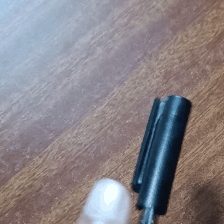

In [39]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

In [40]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: action2
